# 网络可视化(PyTorch)
在这个笔记本中，我们将探索使用*图像梯度*生成新的图像。
当训练一个模型时，我们定义一个损失函数来衡量我们当前对模型表现的不满;然后，我们使用反向传播来计算相对于模型参数的损耗梯度，并对模型参数进行梯度下降以最小化损耗。
这里我们将做一些稍微不同的事情。我们将从一个卷积神经网络模型开始，该模型经过预处理，用于在ImageNet数据集上执行图像分类。我们将使用这个模型来定义一个损失函数，量化我们当前对图像的不满意程度，然后使用反向传播来计算这个损失相对于图像像素的梯度。我们将保持模型不变，并对图像进行梯度下降*，以合成一个新的图像，使损失最小化。
在本笔记本中，我们将探讨三种技术的图像生成:
1. **显著性映射**:显著性映射是一种快速判断图像的哪一部分影响了网络的分类决策的方法。
2. **欺骗图像**:我们可以扰乱一个输入图像，使它看起来对人类是一样的，但会被预先训练好的网络错误分类。
3. **类可视化**:我们可以合成一个图像来最大化特定类的分类分数;这可以给我们一些感觉，网络正在寻找什么，当它分类的图像类。

本笔记本使用**PyTorch**;我们提供了另一个笔记本，它探索了TensorFlow中相同的概念。你只需要完成这两个笔记本中的一个。

In [1]:
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 辅助功能
我们的预训练模型是在经过预处理的图像上进行训练的，这些图像是通过减去每一种颜色的平均值并除以每一种颜色的标准差得到的。我们定义了一些辅助函数来执行和取消这个预处理。你不需要在这里做任何事。

In [2]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

# 预训练模型
对于我们所有的图像生成实验，我们将从一个卷积神经网络开始，该网络经过预先训练在ImageNet上执行图像分类。我们可以使用任何模型在这里，但为了这个任务的目的，我们将使用SqueezeNet[1]，它实现的精度可与AlexNet相比，但大大减少了参数计数和计算复杂性。
使用SqueezeNet而不是AlexNet或VGG或ResNet意味着我们可以很容易地在CPU上执行所有图像生成实验。

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [3]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

## 加载一些ImageNet图像
我们提供了一些来自ImageNet ILSVRC 2012分类数据集验证集的示例图像。要下载这些图像，请打开'cs231n/datasets/'并运行'get_imagenet_val.sh'。
由于它们来自验证集，我们的预训练模型在训练期间没有看到这些图像。
运行以下单元格来可视化这些图像，以及它们的ground-truth标签。

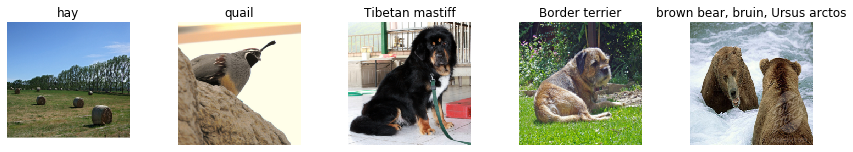

In [4]:
from cs231n.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# 显著地图
使用这个预训练的模型，我们将计算类显著性映射，如[2]的3.1节所述。
一个**显著性图**告诉我们图像中的每个像素对该图像的分类分数的影响程度。为了计算它，我们计算了对应于正确类(一个标量)的非标准化分数相对于图像像素的梯度。如果图像有形状' (3,H, W) '，那么这个梯度也将有形状' (3,H, W) ';对于图像中的每一个像素，这个梯度告诉我们，如果像素变化很小，分类分数会改变多少。为了计算显著性图，我们取梯度的绝对值，然后取三个输入通道上的最大值;因此，最终的显著性映射具有形状' (H, W) '，并且所有条目都是非负的。

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

### Hint: PyTorch `gather` method
Recall in Assignment 1 you needed to select one element from each row of a matrix; if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor or Variable of shape `(N, C)` and `y` is a PyTorch Tensor or Variable of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`s.gather(1, y.view(-1, 1)).squeeze()`

will be a PyTorch Tensor (or Variable) of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [5]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[-0.1177, -0.4221, -0.0506,  0.2390, -0.5043],
        [ 0.2295, -0.1320,  0.9307, -0.6256,  1.1214],
        [-0.2634,  1.0417, -0.0370, -1.3369,  0.3155],
        [ 0.0907, -0.0353, -0.9319,  2.0409, -0.3091]])
tensor([1, 2, 1, 3])
tensor([-0.4221,  0.9307,  1.0417,  2.0409])


In [6]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    # 利用正确分类的score去计算输入图片的梯度。
    # 然后取梯度的绝对值，在3个通道上选择最大的那个值。
    scores=model(X_var)
    scores=scores.gather(1,y_var.view(-1,1)).squeeze()
    # 向量对向量求导
    tmp=scores.backward(torch.ones_like(scores))
    saliency=X_var.grad.data
    saliency,index=torch.max(saliency.abs(),dim=1)
    saliency=saliency.squeeze()
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

一旦你在上面的单元格中完成了实现，运行下面的代码，在来自ImageNet验证集的示例图像上可视化一些类显著性映射:

D:\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


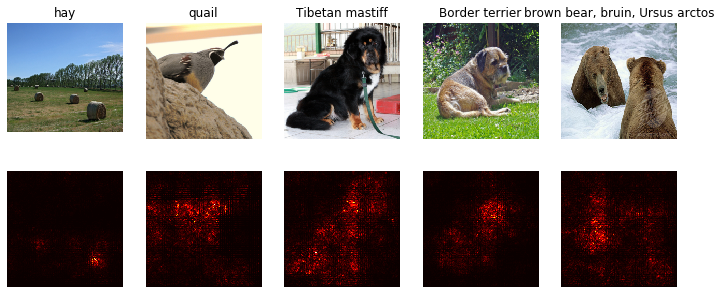

In [7]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

# 愚弄图片
我们还可以使用图像梯度来生成[3]中讨论的“欺骗图像”。给定一个图像和一个目标类，我们可以在图像上执行梯度**上升期**来最大化目标类，当网络将图像分类为目标类时停止。实现以下函数来生成欺骗图像。

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [8]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone()
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    
    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    scores=model(X_fooling_var)
    _,y_predit=scores.max(dim=1)
    iter=0
    while(y_predit!=target_y):
        iter += 1
        if(iter%10==0):
            print("Iteration: %d"% iter)
        # 选择最第一张图片，对应的目标得分
        target_score=scores[0,target_y]
        # 标量直接返回梯度
        target_score.backward()
        
        reg=X_fooling_var.grad/X_fooling_var.grad.norm()
        X_fooling.data+=learning_rate*reg
        # 清除缓存梯度
        X_fooling_var.grad.zero_()
        model.zero_grad()
        scores=model(X_fooling_var)
        _,y_predit=scores.max(dim=1)  
    print("Iteration Count: %d"% iter)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

Run the following cell to generate a fooling image:

In [9]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(Variable(X_fooling))
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Iteration Count: 9


After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

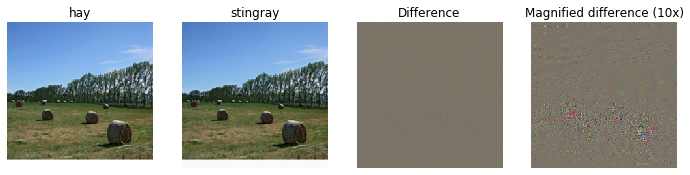

In [10]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# 类可视化
通过从一个随机噪声图像开始，并对一个目标类执行梯度上升，我们可以生成一个网络将识别为目标类的图像。这个想法最初是在[2]中提出的;[3]扩展了这一思想，提出了几种正则化技术，可以提高生成的图像的质量。

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) - R(I)
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [11]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [12]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        score=model(img_var)
        target_score=score[0,target_y]
        target_score.backward()
        im_grad=img_var.grad-2*l2_reg*img_var
        img_var.data+=learning_rate*im_grad/im_grad.norm()
        img_var.grad.zero_()
        model.zero_grad()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

Once you have completed the implementation in the cell above, run the following cell to generate an image of a Tarantula:

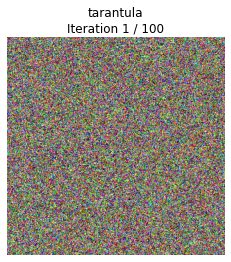

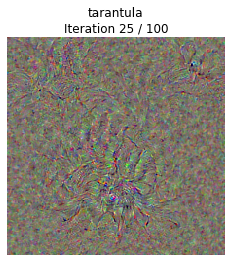

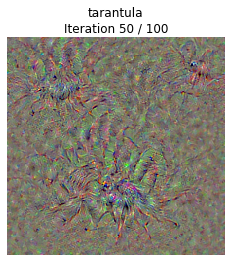

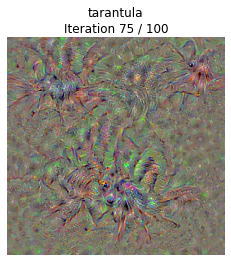

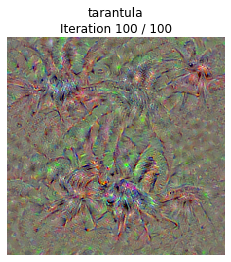

In [13]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus


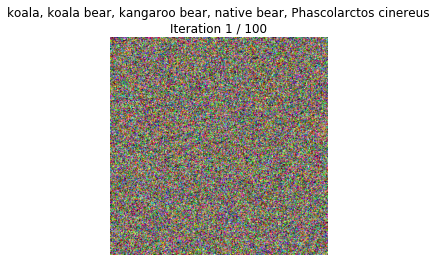

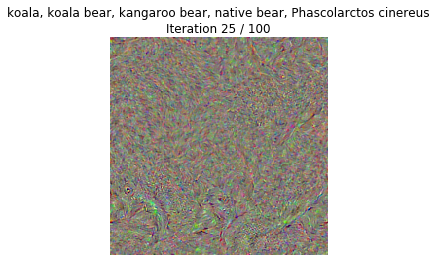

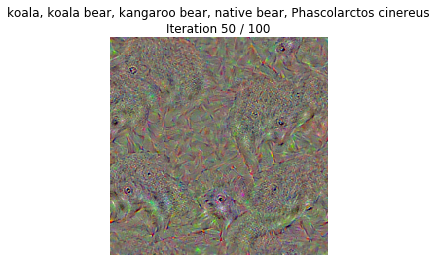

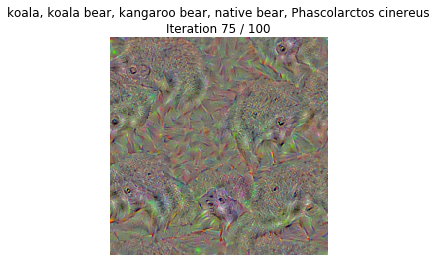

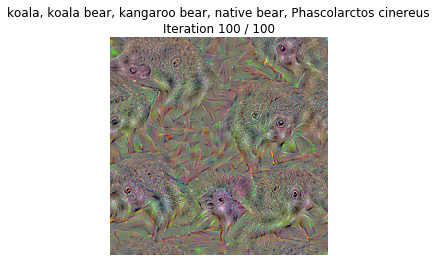

In [14]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)